In [2]:
import os
root = '/content/drive/MyDrive/news_summary'
os.chdir(root)
print(os.getcwd())

/content/drive/MyDrive/news_summary


In [3]:
import pandas as pd
data = pd.read_csv('news_summary_more.csv', encoding='latin-1')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [3]:
# encoder-decoder arch
#Sentence > Tokenizer(tokens) > Embedding > Encoder > Decoder > Seq OP

In [4]:
!pip install contractions
!pip install unicodedata
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 9.5 MB/s 
     |████████████████████████████████| 106 kB 48.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import re
import random
import math
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import contractions
import unicodedata
from collections import Counter
import torch
from torch import nn, optim
from torch.nn import Embedding, LSTM, Dropout, Linear
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab, build_vocab_from_iterator
import spacy
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
print(torch.cuda.is_available())
print(torch.__version__)

False
1.12.1+cu113


In [6]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [7]:
def text_cleaning(text):
  try:
    # online resource 
    text = ''.join(i for i in unicodedata.normalize('NFD', text) if unicodedata.category(i) != 'Mn') # removes accents and unicodes
    text = ' '.join([contractions.fix(i) for i in text.split(' ')]) # fixes contractions
    text = re.sub(r'[" "]+', ' ', text) # replaces large spaces into a single space [\s]+ to \s
    text = re.sub(r'([?\.!,¿])', r' \1 ', text) # adds a space before punc mark
    text = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', text).strip()
    text = re.sub(r'(\\t)|(\\r)|(\\n)|(__+)|(--+)|(~~+)|(\+\++)|(\.\.+)|(\.\s+)|(\-\s+)|(\:\s+)|(\s+.\s+)|(\s+)|(\s+.\s+)', ' ', text) # removes escape chars
    text = re.sub(r'[<>()|&©ø\[\]\'\",;?~*!]', ' ', text) #remove <>()|&©ø"',;?~*!
    text = re.sub(r'(mailto:)', ' ', text)  #remove mailto:
    text = re.sub(r'(\\x9\d)', ' ', text)  #remove \x9* in text
    text = re.sub(r'([iI][nN][cC]\d+)', 'INC_NUM', text)  #replace INC nums to INC_NUM
    text = re.sub(r'([cC][mM]\d+)|([cC][hH][gG]\d+)', 'CM_NUM', text)  #replace CM# and CHG# to CM_NUM
    text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', '', text) # removes http tag
    return text.lower()

  except Exception as e:
    raise Exception(str(e))

In [8]:
data['headlines'] = data['headlines'].apply(text_cleaning)
data['text'] = data['text'].apply(text_cleaning)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.1770e+03,
        6.4817e+04, 3.2372e+04, 3.2000e+01, 0.0000e+00, 1.0000e+00]),
 array([ 1. , 10.7, 20.4, 30.1, 39.8, 49.5, 59.2, 68.9, 78.6, 88.3, 98. ]),
 <a list of 10 Patch objects>)

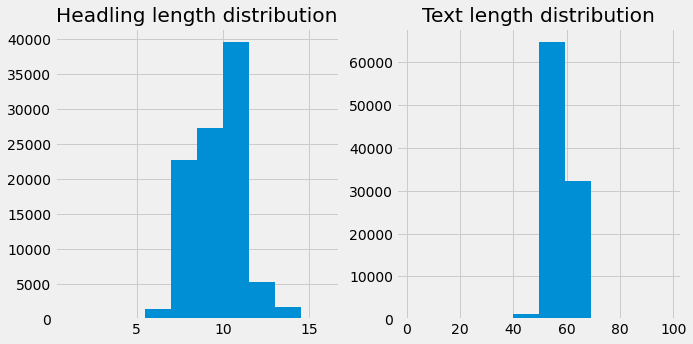

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title(f'Headling length distribution')
plt.hist(data['headlines'].str.split().apply(len))
plt.subplot(1, 2, 2)
plt.title(f'Text length distribution')
plt.hist(data['text'].str.split().apply(len))

In [10]:
def yield_tokens(itertokens):
  for sentence in itertokens:
      yield sentence.strip().split(' ')

In [11]:
text_vocab = build_vocab_from_iterator(yield_tokens(data['text'].values), min_freq=1, specials =['<bos>','<eos>','<pad>','<unk>'])
headline_vocab = build_vocab_from_iterator(yield_tokens(data['text'].values), min_freq=1, specials =['<bos>','<eos>','<pad>','<unk>'])

In [12]:
data.iloc[96646]['text']

'japan largest toilet maker toto has opened high tech experiential showroom called concept in san francisco where it has invited people to pee and poo to experience its different toilet seats on entering the bathroom the lights turn on and the toilet seat lifts up automatically during the demo space sceneries are also projected on the bathroom walls .'

In [13]:
text_vocab['francisco']

5106

In [14]:
text_vocab.set_default_index(text_vocab[[word for word in list(text_vocab.get_itos()) if word == '<unk>'][0]])
headline_vocab.set_default_index(headline_vocab[[word for word in list(headline_vocab.get_itos()) if word == '<unk>'][0]])

In [15]:
text_vocab[[word for word in list(text_vocab.get_itos()) if word == '<unk>'][0]]

3

In [16]:
len(text_vocab), len(headline_vocab)

(78095, 78095)

In [17]:
len(set(text_vocab.get_itos())), len(set(headline_vocab.get_itos()))

(78095, 78095)

In [18]:
sentence_list = ['that is a cat', 'that is not a dog']
print(text_vocab['aaaaaaa'], headline_vocab['dddddddddddd'])
text_vocab['san'], headline_vocab['san']

3 3


(3473, 3473)

In [19]:
sent = 'hello world'
' '.join([word.lower().strip() for word in sent.split(' ')][::-1])

'world hello'

In [20]:
class CustomDataset(Dataset):
  def __init__(self, text, headline, text_vocab, headline_vocab):
    super(CustomDataset, self).__init__()
    self.text = text # list of sentences
    self.headline = headline # list of sentences
    self.text_vocab = text_vocab
    self.headline_vocab = headline_vocab
  
  def __len__(self):
    assert len(self.text) == len(self.headline)
    return len(self.text)

  def encode_text(self, text):
    # encode text will be reversed so that the last timestamp/word of the text data adds more value to the beginning of the headline
    return ' '.join([word.lower().strip() for word in text.split(' ')][::-1])

  def tokenize_text(self, vocab, text):
    tokens = [vocab['<bos>']]
    for word in text.split(' '):
      tokens.append(vocab[word])
    tokens.append(vocab['<eos>'])
    return tokens

  def __getitem__(self, idx):
    text = self.encode_text(self.text[idx])
    headline = self.headline[idx]

    text_token = self.tokenize_text(self.text_vocab, text)
    headline_token = self.tokenize_text(self.headline_vocab, headline)

    return torch.tensor(text_token), torch.tensor(headline_token)

In [21]:
ind = np.random.choice(range(data.shape[0]), int(0.8*data.shape[0]), replace=False)
train_data = data.iloc[ind,:]
test_data = data[~data.index.isin(ind)]

In [22]:
train_text = train_data['text']
train_headlines = train_data['headlines']
val_text = test_data['text']
val_headlines = test_data['headlines']

In [23]:
train_text.shape, train_headlines.shape, val_text.shape, val_headlines.shape, data.shape

((78720,), (78720,), (19681,), (19681,), (98401, 2))

In [24]:
train_text.shape[0]

78720

In [25]:
train_dataset = CustomDataset(train_text.values, train_headlines.values, text_vocab, headline_vocab)
val_dataset = CustomDataset(val_text.values, val_headlines.values, text_vocab, headline_vocab)

In [26]:
headline_vocab['<eos>']

1

In [27]:
class CustomPadding:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    text = [item[0] for item in batch]
    headline = [item[1] for item in batch]

    text = pad_sequence(text, batch_first=False, padding_value=self.pad_idx)
    headline = pad_sequence(headline, batch_first=False, padding_value=self.pad_idx)
    #print(text.shape, headline.shape)

    return text, headline

In [28]:
c = CustomPadding(pad_idx=2)
padded = c(train_dataset)

In [29]:
padded[0].shape, padded[1].shape, padded[0].shape, padded[1].shape

(torch.Size([100, 78720]),
 torch.Size([22, 78720]),
 torch.Size([100, 78720]),
 torch.Size([22, 78720]))

In [28]:
batch_size = 128

In [29]:
text_vocab['<pad>'], headline_vocab['<pad>']

(2, 2)

In [30]:
# both text and headling padding index is 2
# post padding with the max text and headline text
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=CustomPadding(pad_idx=train_dataset.text_vocab['<pad>'])
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=CustomPadding(pad_idx=val_dataset.text_vocab['<pad>'])
)

In [31]:
next(iter(train_loader))[0]

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    9,     9,     9,  ...,     9,     9,     9],
        [ 2822,    73, 11213,  ...,  9027,  1570,  1800],
        ...,
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2]])

In [32]:
next(iter(val_loader))[1]

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [10674, 41014,  7176,  ...,   327,   379,    35],
        [15904,  3157, 11428,  ...,  4164, 12197,  5238],
        ...,
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2]])

In [33]:
headline_vocab.get_itos()[0:10]

['<bos>', '<eos>', '<pad>', '<unk>', 'the', 'to', 'in', 'of', 'and', '.']

# Model Building

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [36]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = Embedding(input_dim, emb_dim)
        self.lstm = LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, (hidden_state, cell_state) = self.lstm(x)
        return hidden_state, cell_state

In [37]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = Embedding(output_dim, emb_dim)
        self.lstm = LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = Dropout(dropout)
        self.fc = Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden_state, cell_state):
        x = x.unsqueeze(0)
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state))
        preds = self.fc(outputs.squeeze(0))
        return preds, hidden_state, cell_state

In [38]:
class Model(nn.Module):
  def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
  def forward(self, x, y, teacher_force_ratio=0.75):  
      target_len = y.shape[0]
      batch_size = y.shape[1]
      target_vocab_size = self.decoder.output_dim  # vocab size
      
      outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
      
      # Encode the source text using encoder
      hidden_state, cell_state = self.encoder(x)
      
      # First input is <bos>
      input = y[0,:]
      
      # Decode the encoded vector using decoder
      for t in range(1, target_len):
          output, hidden_state, cell_state = self.decoder(input, hidden_state, cell_state)
          outputs[t] = output
          teacher_force = random.random() < teacher_force_ratio
          pred = output.argmax(1)
          input = y[t] if teacher_force else pred
      
      return outputs

In [39]:
input_size = len(text_vocab)
output_size = len(headline_vocab)
emb_dim = 128
hidden_dim = 256
n_layers = 2
dropout = 0.2

encoder = Encoder(input_size, emb_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(output_size, emb_dim, hidden_dim, n_layers, dropout)
model = Model(encoder, decoder).to(device)

In [40]:
# initialize weights with uniform distribution
for name, param in model.named_parameters():
  nn.init.uniform_(param.data, -0.09, 0.09)

In [41]:
# total trainable parameters
sum([p.numel() for p in model.parameters() if p.requires_grad])

41905935

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=text_vocab.get_stoi()['<pad>'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, min_lr=0.00001)

In [44]:
def train_model(model, data_loader, optimizer, criterion, clip):
  model.train(mode=True)
  epoch_loss = 0

  for i, batch, in tqdm(enumerate(data_loader), total=len(data_loader), position=0, leave=True):
    texts = batch[0].to(device)
    headlines = batch[1].to(device)

    optimizer.zero_grad()

    output = model(texts, headlines) # output size will be headling_lenXbatch_sizeXvocab_size
    output_size = output.shape[-1]
    output = output[1:].view(-1, output_size) # resizing to dimXvocab_size for loss function
    headlines = headlines[1:].view(-1) # excluding <bos>

    print(output.shape, headlines.shape)

    loss = criterion(output, headlines)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss+= loss.item()

  return epoch_loss/ len(data_loader)


In [45]:
def evaluate_model(model, data_loader, criterion):
  model.train(mode=True)
  epoch_loss = 0

  with torch.no_grad():
    for i, batch in tqdm(enumerate(data_loader), total=len(data_loader), position=0, leave=True):
      texts = batch[0].to(device)
      headlines = batch[1].to(device)

      output = model(texts, headlines, teacher_force_ratio=0) 
      output_size = output.shape[-1]
      output = output[1:].view(-1, output_size) # resizing to dimXvocab_size for loss function
      headlines = headlines[1:].view(-1) # excluding <bos>

    
      loss = criterion(output, headlines)
      epoch_loss+= loss.item()

  return epoch_loss/ len(data_loader)

In [46]:
def epochtime(start_time, end_time):
  time = end_time - start_time
  mins = int(time/60)
  secs = int(time - (mins*60))
  return mins, secs

In [ ]:
epochs = 50
clip = 1
best_val_loss = float('inf')

for epoch in range(epochs):
  start_time = time.time()

  train_loss = train_model(model, train_loader, optimizer, criterion, clip)
  val_loss = evaluate_model(model, val_loader, criterion)
  scheduler.step(val_loss)
  end_time = time.time()

  time_mins, time_secs = epochtime(start_time, end_time)

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pt')

  print(f'epoch {epoch+1} time {time_mins}m : {time_secs}s')
  print(f'train loss: {round(train_loss,2)}')
  print(f'val loss: {round(val_loss,2)}')

Output hidden; open in https://colab.research.google.com to view.

In [42]:
model_path = './best_model.pt'
if torch.cuda.is_available():
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Inference

In [43]:
def inference(model, text):
  model.train(mode=False)
  summary = []

  with torch.no_grad():
    text = text.to(device)

    hidden_state, cell_state = model.encoder(text)
    input = torch.tensor([headline_vocab['<bos>']]).to(device) #first word <bos> to the decoder

    for i in range(1, 10): # output summary will be 10 words
      output, hidden_state, cell_satte = model.decoder(input, hidden_state, cell_state)
      pred = output.argmax(1)  
      if pred == headline_vocab['<eos>']:
        break
      summary.append(headline_vocab.get_itos()[pred.item()])
      input = pred

  return " ".join(summary)

In [44]:
for batch in val_loader:
  break

In [45]:
text_vectors = np.vectorize(lambda x: text_vocab.get_itos()[x])
headline_vectors = np.vectorize(lambda x: headline_vocab.get_itos()[x])

In [46]:
for i in range(3):
  print(f'actual text: {" ".join([word for word in text_vectors(batch[0][:, i]) if word not in ["<bos>", "<eos>", "<pad>"]])}')
  print(f'actual text: {" ".join([word for word in headline_vectors(batch[1][:, i]) if word not in ["<bos>", "<eos>", "<pad>"]])}')
  print(f'predicted text: {inference(model, batch[0][:,i].reshape(-1, 1))}')

actual text: . chief cbi as removal his after to transferred was he post the services fire dg as join immediately to him directed ministry the thursday on director as tenure fixed his of day last the on work join to him asked ministry home the retired him consider to training and personnel of department the told verma alok director cbi ex after weeks
actual text: govt directs alok verma to join work day before his retirement
predicted text: i am not want to do not want to
actual text: . singh laxman candidate bsp and mla sitting of death the to due delayed was seat ramgarh the to election the assembly member the in seats to total its taken has congress victory this with bypoll the in votes of margin with singh sukhwant bjp defeating by rajasthan in seat assembly ramgarh the won zubair shafia candidate congress
actual text: cong wins ramgarh bypoll in rajasthan takes total to seats
predicted text: bjp <unk> bjp mla bjp bjp bjp bjp bjp
actual text: . march on eu the leave to scheduled is